In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import gzip

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

def convert2pkl(path = "Dataset/reviews_Movies_and_TV_5.json.gz"):\
    
    df = getDF(path)
    df = df[['reviewText', 'overall']]
    
    # Remove half of the reviews
    df = df.sample(frac=0.5, random_state=42)
    
    # Specify the pickle file path
    pkl_path = "Dataset/Movies_and_TV.pkl"
    
    # Save the DataFrame as a pickle file
    df.to_pickle(pkl_path)
    
    print(f"Conversion complete. Pickle file saved at: {pkl_path}")

convert2pkl()

In [2]:
def load_data(path="Dataset/Movies_and_TV.pkl"):
    df = pd.read_pickle(path)

    reviews = np.array(df['reviewText'])
    ratings = np.array(df['overall'])

    low_rating_indices = np.where((ratings >= 1) & (ratings <= 2))[0]
    reviews_1 = reviews[low_rating_indices]
    ratings_1 = ratings[low_rating_indices]

    # Filter out reviews shorter than 200 words
    temp = df[df['reviewText'].apply(lambda x: len(x.split()) > 200)]
    reviews = np.array(temp['reviewText'])
    ratings = np.array(temp['overall'])

    high_rating_indices = np.where((ratings >= 3) & (ratings <= 5))[0]
    reviews_2 = reviews[high_rating_indices]
    ratings_2 = ratings[high_rating_indices]

    # Filter out reviews between 100 and 200 words
    temp = df[df['reviewText'].apply(lambda x: len(x.split()) < 200 and len(x.split()) > 100)]
    reviews = np.array(temp['reviewText'])
    ratings = np.array(temp['overall'])

    three_rating_indices = np.where((ratings == 3))[0]
    random_indices = np.random.choice(three_rating_indices, size=35000, replace=False)
    reviews_3 = reviews[random_indices]
    ratings_3 = ratings[random_indices]

    reviews = np.concatenate((reviews_1, reviews_2, reviews_3))
    ratings = np.concatenate((ratings_1, ratings_2, ratings_3))

    return reviews, ratings

review, sentiment = load_data()
MAX_WORDS = 1000  # Maximum number of words allowed in a review

# Cut reviews with more than 400 words to 400 words
review = [r[:MAX_WORDS] if len(r.split()) > MAX_WORDS else r for r in review]

df = pd.DataFrame({'reviewText':review, 'overall':sentiment})
df.to_pickle("Dataset/Movies_and_TV_clean.pkl")

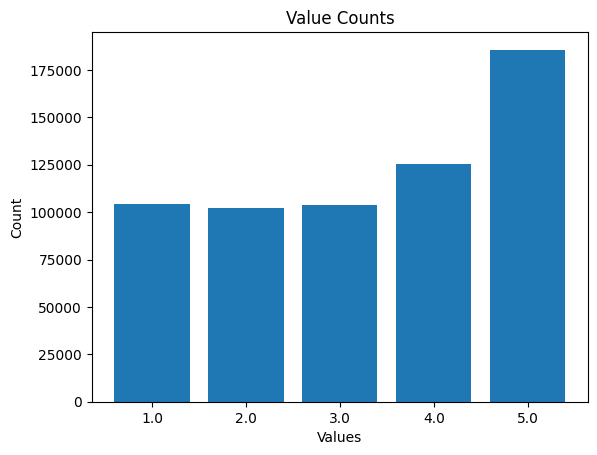

In [3]:
# Count the occurrences of each value
unique_values, counts = np.unique(sentiment, return_counts=True)

# Create x-axis values
x = np.arange(len(unique_values))

# Plot the counts as a bar plot
plt.bar(x, counts, tick_label=unique_values, align='center')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Value Counts')

# Show the plot
plt.show()

In [2]:
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(["mr", "ms", "mrs", "dr", "film", "movie", "really", "one", "TV"])  # Add more stop words as needed
    text = ' '.join(word for word in text.split() if word.lower() not in stop_words or word.lower() == "not")

    # Remove 1-2 length words
    text = ' '.join(word for word in text.split() if len(word) > 2)

    # Remove double spaces
    text = re.sub(r'\s+', ' ', text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

In [3]:
def load_data(path="Dataset/Movies_and_TV_clean.pkl"):
    df = pd.read_pickle(path)
    # Remove half of the reviews
    df = df.sample(frac=0.5, random_state=4)
    df = df.sample(frac=0.5, random_state=42)
    df = df.sample(frac=0.5, random_state=42)
    df['reviewText'] = df['reviewText'].apply(clean_text)

    reviews = np.array(df['reviewText'])
    ratings = np.array(df['overall'])
    
    return reviews, ratings

review, sentiment = load_data()
MAX_WORDS = 400  # Maximum number of words allowed in a review

# Cut reviews with more than 400 words to 400 words
review = [r[:MAX_WORDS] if len(r.split()) > MAX_WORDS else r for r in review]

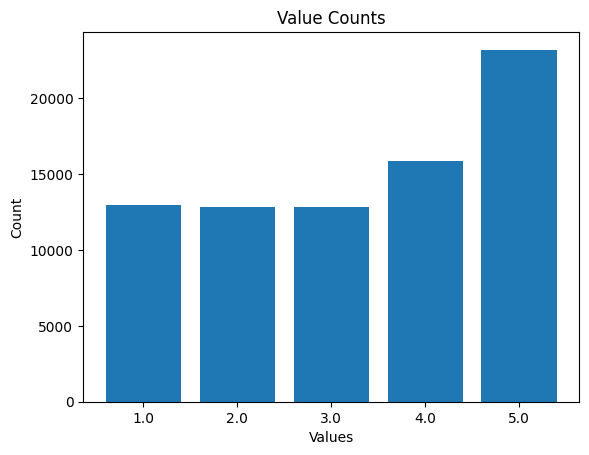

In [4]:
# Count the occurrences of each value
unique_values, counts = np.unique(sentiment, return_counts=True)

# Create x-axis values
x = np.arange(len(unique_values))

# Plot the counts as a bar plot
plt.bar(x, counts, tick_label=unique_values, align='center')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Value Counts')

# Show the plot
plt.show()

Review length (in words):
Mean 138.92 words (89.235298)


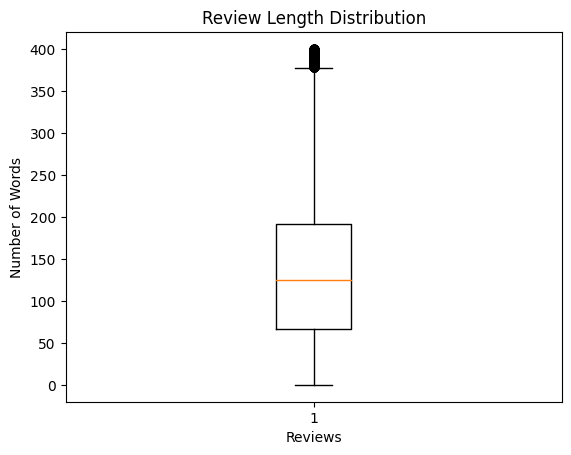

In [5]:
# Summarize review length in words
print("Review length (in words):")
result = [len(x.split()) for x in review]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))

# Plot review length
plt.boxplot(result)
plt.xlabel('Reviews')
plt.ylabel('Number of Words')
plt.title('Review Length Distribution')
plt.show()
del result

In [4]:
from transformers import BertTokenizer
import tensorflow as tf
from keras.utils import to_categorical

def preprocess_data(reviews, sentiment):
    # Initialize the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

    # Tokenization and Conversion to Input IDs
    input_ids = []
    attention_masks = []
    max_sequence_length = 400  # Set your desired sequence length

    for review in reviews:
        encoded_dict = tokenizer.encode_plus(
            review,
            truncation=True,
            max_length=max_sequence_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    # Encoding Labels
    sentiment_encoded = to_categorical(np.array(sentiment) - 1) # Convert sentiment labels to categorical (0-based index)

    return np.array(input_ids), np.array(attention_masks), sentiment_encoded

input_ids, attention_masks, sentiment_encoded = preprocess_data(review, sentiment)

c:\Users\steve\.conda\envs\global\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
    input_ids, sentiment_encoded, attention_masks,
    test_size=0.2, stratify=sentiment_encoded
)

In [3]:
from keras import backend as K
def star_mae(y_true, y_pred):
    true_star = K.sum(y_true * K.arange(0, 5, dtype="float32"), axis=-1)
    pred_star = K.sum(y_pred * K.arange(0, 5, dtype="float32"), axis=-1)
    mae = K.mean(K.abs(true_star - pred_star))
    return mae

In [4]:
from transformers import TFAutoModel
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model

# Load pre-trained tinyBERT model
tinybert_model = TFAutoModel.from_pretrained('prajjwal1/bert-tiny', from_pt=True)

# Input layers
input_ids = Input(shape=(400,), dtype=np.int32, name='input_ids')
attention_mask = Input(shape=(400,), dtype=np.int32, name='attention_mask')

# tinyBERT embeddings
outputs = tinybert_model(input_ids, attention_mask=attention_mask)
pooled_output = outputs[0][:, 0, :]  # Extract pooled output (CLS token)

# Keras layers
x = BatchNormalization()(pooled_output)
x = Dense(128, activation='gelu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='gelu')(x)

# Output layer
output = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=star_mae)
model.summary()
model.load_weights('Weights/Sentiment Analysis Transformer.h5')  

c:\Users\steve\.conda\envs\global\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 400)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  4385920     ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 400,                                           

In [ ]:
# import tensorflow as tf
# from keras.layers import Dense, Input, Dropout, LayerNormalization, MultiHeadAttention, Embedding, GlobalAveragePooling1D, Layer
# from keras.models import Model

# class PositionalEncoding(Layer):
#     def __init__(self):
#         super(PositionalEncoding, self).__init__()

#     def call(self, inputs):
#         seq_length = tf.shape(inputs)[1]
#         d_model = inputs.shape[2]
#         position = tf.reshape(tf.range(seq_length, dtype=tf.float32), (1, seq_length, 1))
#         div_term = tf.exp(-tf.math.log(10000.0) * tf.range(0, d_model, 2, dtype=tf.float32) / d_model)
#         pos_enc = tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)
#         return inputs + pos_enc

# def TransformerModel(input_shape, num_classes, num_blocks=4, d_model=128, num_heads=8, dff=512, dropout_rate=0.1):
#     inputs = Input(shape=input_shape)
#     x = Embedding(input_dim=input_shape[0], output_dim=d_model)(inputs)
#     x = PositionalEncoding()(x)
    
#     for _ in range(num_blocks):
#         # Multi-head self-attention
#         attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
#         attn_output = Dropout(dropout_rate)(attn_output)
#         x = LayerNormalization(epsilon=1e-6)(x + attn_output)

#         # Feed-forward neural network
#         ffn_output = Dense(dff, activation='relu')(x)
#         ffn_output = Dense(d_model)(ffn_output)
#         ffn_output = Dropout(dropout_rate)(ffn_output)
#         x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

#     x = GlobalAveragePooling1D()(x)
#     x = Dropout(dropout_rate)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# # Example usage
# input_shape = (200, )  # Sequence length of 100
# num_classes = 5  # 5 sentiment classes
# model = TransformerModel(input_shape, num_classes)

# # Print model summary
# model.summary()
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# # model.load_weights("Weights/Sentiment Analysis Transformer.h5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 128)     25600       ['input_2[0][0]']                
                                                                                                  
 positional_encoding_1 (Positio  (None, 200, 128)    0           ['embedding_1[0][0]']            
 nalEncoding)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 200, 128)    527488      ['positional_encoding_1[0][

In [8]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='star_mae', 
    patience=2, 
    mode='min'
)

In [9]:
model.fit([x_train, z_train], y_train,
          epochs=10, 
          verbose=1,
          validation_data=([x_test, z_test], y_test),
          callbacks=[early_stopping]
)

Epoch 1/10
1943/1943 [==============================] - 204s 102ms/step - loss: 1.0159 - star_mae: 0.6318 - val_loss: 0.9771 - val_star_mae: 0.6172
Epoch 2/10
1943/1943 [==============================] - 198s 102ms/step - loss: 0.8712 - star_mae: 0.5272 - val_loss: 1.0301 - val_star_mae: 0.5865
Epoch 3/10
1943/1943 [==============================] - 198s 102ms/step - loss: 0.6922 - star_mae: 0.4032 - val_loss: 1.1534 - val_star_mae: 0.6073
Epoch 4/10
1943/1943 [==============================] - 202s 104ms/step - loss: 0.5210 - star_mae: 0.2970 - val_loss: 1.3774 - val_star_mae: 0.6124
Epoch 5/10
1943/1943 [==============================] - 200s 103ms/step - loss: 0.4086 - star_mae: 0.2319 - val_loss: 1.5502 - val_star_mae: 0.6250
Epoch 6/10
1943/1943 [==============================] - 201s 103ms/step - loss: 0.3255 - star_mae: 0.1845 - val_loss: 1.7764 - val_star_mae: 0.6191
Epoch 7/10
1943/1943 [==============================] - 197s 102ms/step - loss: 0.2707 - star_mae: 0.1559 - val_

In [10]:
#Save model
model.save('Weights/Sentiment Analysis Transformer.h5')  

In [5]:
from transformers import BertTokenizer

def preprocessing_data(review, tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')):
    encoded_dict = tokenizer.encode_plus(
            review,
            truncation=True,
            max_length=400,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
    
    input_id = np.array(encoded_dict['input_ids'])
    attention_mask = np.array(encoded_dict['attention_mask'])
    
    return input_id, attention_mask

In [8]:
star = [1, 2, 3, 4, 5]
text = input()
text = clean_text(text)
input_id, attention_mask = preprocessing_data(text)
result = np.argmax(model.predict([input_id, attention_mask]))
star[result]

1/1 [==============================] - 0s 35ms/step


5